# Mini Project 1

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

## Portfolio Optimization

I am using this notebook to design a better portfolio optimizer than the one I submitted before the deadline of the course. The hope is to actually be able to manage assets using the algorithm.

In [178]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
import datetime as dt
sns.set_style('darkgrid')

In order to create a stock portfolio, let us begin by scraping S&P 500 data off of wikipedia for the tickers.

In [179]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_df = pd.read_html(url, header=0)[0]

# Clean up DataFrame
sp500_df = sp500_df[['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry']]
sp500_df.columns = ['Ticker', 'Company', 'Sector', 'Industry']


# Group by sector or industry
sector_groups = sp500_df.groupby('Sector')
industry_groups = sp500_df.groupby('Industry')

In [180]:
sp500_df['Sector'].value_counts()

Sector
Industrials               78
Financials                73
Information Technology    68
Health Care               60
Consumer Discretionary    51
Consumer Staples          38
Utilities                 31
Real Estate               31
Materials                 26
Communication Services    23
Energy                    23
Name: count, dtype: int64

I am trying to write a customizable portfolio optimizer. So here, we select 3 sectors at random and select a total of 20 stocks from the 4 sectors to work with.

In [181]:
chosen_sectors = np.random.choice(sp500_df['Sector'].unique(), size=4, replace=False)
print("Stocks will be chosen from: ", chosen_sectors)

Stocks will be chosen from:  ['Utilities' 'Financials' 'Materials' 'Communication Services']


In [182]:
ticker_list = np.array(sp500_df[sp500_df['Sector'].isin(chosen_sectors)]['Ticker'])
stock_tickers = np.random.choice(ticker_list, size=20, replace=False)
print('Chosen Stocks to be optimized in portfolio: ', stock_tickers)

Chosen Stocks to be optimized in portfolio:  ['AON' 'AXP' 'V' 'MS' 'CBOE' 'IP' 'PPL' 'MTCH' 'DD' 'EG' 'WEC' 'HBAN'
 'TFC' 'PNW' 'CF' 'WRB' 'HIG' 'META' 'IVZ' 'AEP']


In [202]:
# stock_tickers = ['AMZN', 'MSFT', 'ANET', 'ICLN', 'FBCG', 'XLC', 'FBCV', 'JEPQ', 'SCHD', 'VGT', 'VTI', 'VPU', 'VIG', 'RIVN', 'LLY', 'GOOGL', 'MPWR', 'SOXL', 'SKYY', 'BOTZ', 'VOO', 'SPY']
stock_tickers = ['BOTZ', 'FBCG', 'VIG', 'FBCV', 'SOXL', 'VTI', 'SPY', 'JEPQ', 'SCHD', 'SKYY', 'XLC', 'GOOGL', 'VOO']

I intend to include liquidity into consideration while optimizing the portfolio, hence I need to download both the stock price at closing and the volume traded.

In [203]:
data_download = yf.download(stock_tickers, start="2024-02-28", end="2025-06-28")
data_download.dropna(axis=1, inplace=True)  # Drop stocks with incomplete data

data = data_download['Close']
volume_data = data_download['Volume']

[*********************100%***********************]  13 of 13 completed


Sample code to get Fundamentals (future implementations)

In [ ]:

ticker = 'AAPL'
stock = yf.Ticker(ticker)

# Get key fundamentals
info = stock.info

# Display common fundamental metrics
fundamentals = {
    "Symbol": ticker,
    "Company Name": info.get("longName"),
    "Sector": info.get("sector"),
    "Market Cap": info.get("marketCap"),
    "P/E Ratio (TTM)": info.get("trailingPE"),
    "EPS (TTM)": info.get("trailingEps"),
    "Forward P/E": info.get("forwardPE"),
    "Dividend Yield": info.get("dividendYield"),
    "Beta": info.get("beta"),
    "52 Week High": info.get("fiftyTwoWeekHigh"),
    "52 Week Low": info.get("fiftyTwoWeekLow")
}
print(fundamentals)

{'Symbol': 'AAPL', 'Company Name': 'Apple Inc.', 'Sector': 'Technology', 'Market Cap': 3189540126720, 'P/E Ratio (TTM)': 33.26324, 'EPS (TTM)': 6.42, 'Forward P/E': 25.697954, 'Dividend Yield': 0.51, 'Beta': 1.211, '52 Week High': 260.1, '52 Week Low': 169.21}


In [204]:
avg_volume = volume_data.mean()
volume_vec = avg_volume.values
# Normalize volume_vec
volume_vec -= np.mean(volume_vec)
volume_vec /= np.linalg.norm(volume_vec)
print(volume_vec)

[-0.15650506 -0.15713529 -0.16227433  0.11953468 -0.1225787  -0.04478994
 -0.1607631   0.8064114   0.38818312 -0.15378469 -0.10522201 -0.13225523
 -0.11882084]


Calculate daily returns and covariances. Using Ledoit-Wolf covariance as a better estimator of covariance

In [205]:
daily_returns = (data/data.shift(1)).dropna()  - 1
# cov_matrix = daily_returns.cov()
mean_returns = daily_returns.mean()
# annual_cov_matrix = cov_matrix * 252

from sklearn.covariance import LedoitWolf
cov_matrix = LedoitWolf().fit(daily_returns).covariance_
annual_cov_matrix = cov_matrix * 252

Visualize covariance matrix

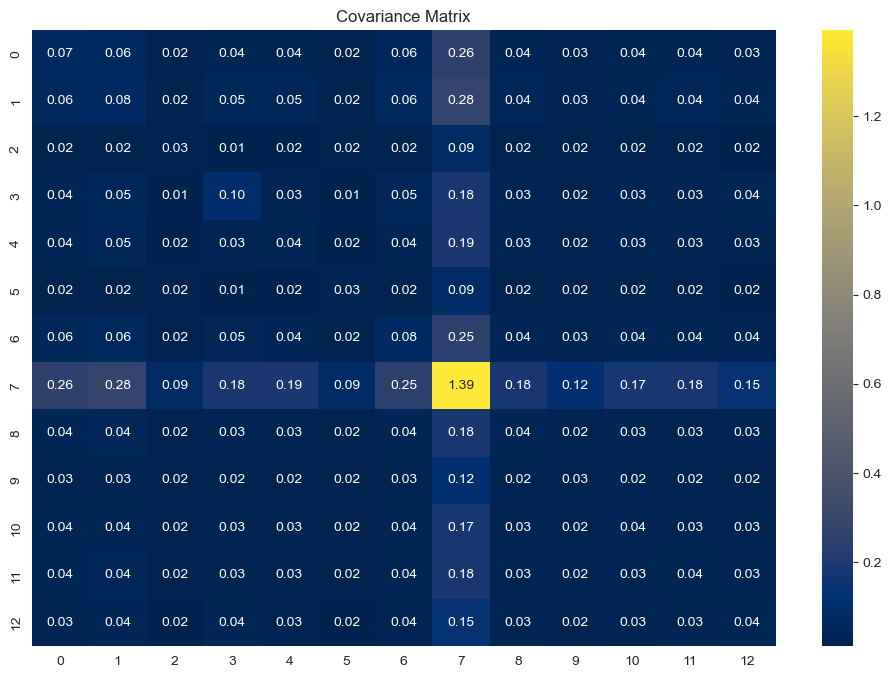

In [206]:
plt.figure(figsize = (12,8))
sns.heatmap(annual_cov_matrix, annot=True, cmap='cividis', fmt ='.2f')
plt.title('Covariance Matrix')
plt.show()

Consider a portfolio of stocks $\{S_1, S_2, ..., S_N\}$ with weights $\{w_1, w_2, ..., w_N\}$. The expected value of the portfolio is
$$
\mathbb{E}[P] = \sum_{i = 1}^N w_i\ \mathbb{E}[S_i]
$$

We can use the annualized average daily simple return for $\mathbb{E}[S_i]$. The variance of the portfolio is given by

$$
\sigma^2[P] = \sum_{i,j} w_i\text{Cov}(S_i, S_j) w_j = w^T\cdot \Sigma \cdot w
$$
where $\Sigma$ is the covariance matrix and $\cdot$ indicates matrix multiplication.

Finally, assume that the average traded volume of stock $S_i$ is $V_i$. Low $V_i$ implies low liquidity, which means that you cannot sell much stock without changing its price in the market. We want to punish low liquidity. 

Thus, we obtain the _liquidity aware objective function_ with a free parameter $\lambda$,
$$
    \mathcal{O}[w] = w^T\cdot\Sigma\cdot w + \lambda\left(\frac{w^T\cdot w}{V}\right)
$$

In what follows, we construct this objective function given a set of stocks and minimize it using scipy.optimize


In [207]:
n_assets = len(mean_returns)

def liquidity_aware_objective(weights, cov_matrix, volume_vector, lambd, lambdaRidge=0.05):
    portfolio_variance = weights.T @ cov_matrix @ weights
    liquidity_penalty = lambd*np.sum(weights**2 / volume_vector)
    ridge_penalty = lambdaRidge * np.sum(weights**2)
    return portfolio_variance + liquidity_penalty + ridge_penalty

def get_constraints(mu, target_return):
    constraints = (
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # Fully invested
        {'type': 'ineq', 'fun': lambda weights: weights @ mu - target_return}, # Return constraint
        )
    return constraints

Calculate efficient frontier:

Efficient Frontier is a set of portfolios that satisfy the condition that no other portfolio exists with a higher expected return but with the same standard deviation of return (i.e., the risk).

In [208]:
mu = mean_returns
cov = annual_cov_matrix
volume_vector = volume_vec
n_points = 100
lambd = 0
lambdaRidge = 0.01

target_returns = np.linspace(mu.min(), mu.max(), n_points)

risks = []
returns = []
weights_list = []

# Define an initial guess for asset weights (e.g., equal weights)
initial_weights = np.array([1/n_assets] * n_assets)


for target in target_returns:
    constraints = get_constraints(mu, target)
    x0 = initial_weights  # Initial guess

    result = minimize(
        liquidity_aware_objective, x0,
        args=(cov, volume_vector, lambd),
        method='SLSQP',
        constraints=constraints,
        bounds = [(0.001, 1.0)] * n_assets
    )
    if result.success:
        optimal_weights = result.x
        portfolio_return = optimal_weights @ mu
        portfolio_risk = np.sqrt(optimal_weights.T @ cov @ optimal_weights)
        returns.append(portfolio_return)
        risks.append(portfolio_risk)
        weights_list.append(optimal_weights)
    else:
        print("Optimization failed at return:", target)

Optimization failed at return: 0.0015333258428376804


/opt/miniconda3/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/opt/miniconda3/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/opt/miniconda3/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:493: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])
/opt/miniconda3/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:499: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_ieq = vstack([con['jac'](x, *con['args'])


Plot the efficient frontier:

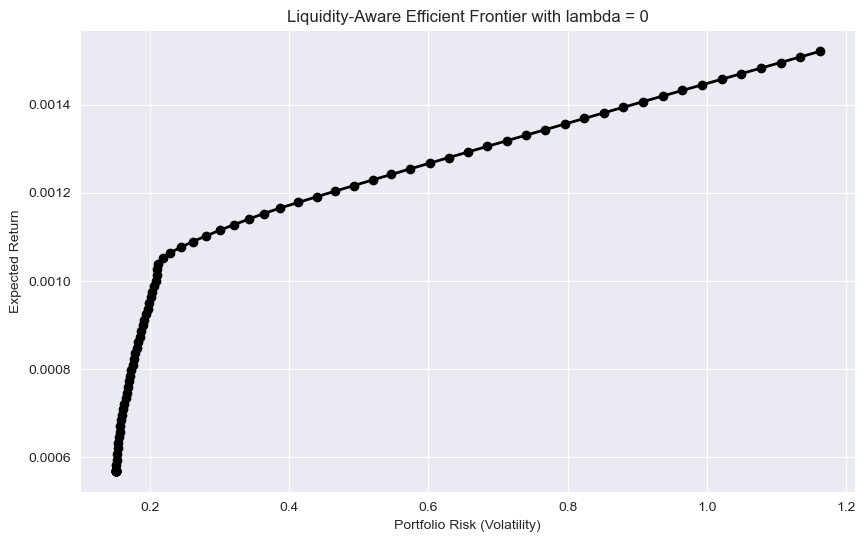

In [209]:
plt.figure(figsize=(10, 6))
plt.plot(risks, returns, '-o', linewidth=2, color='black')
plt.xlabel('Portfolio Risk (Volatility)')
plt.ylabel('Expected Return')
plt.title("Liquidity-Aware Efficient Frontier with lambda = "+str(lambd))
plt.grid(True)
plt.show()

Enclose the above code in a function so that we can run it for different lambdas:

In [210]:
def get_efficient_frontier(mu, cov, volume_vector, lambd, n_points):
    n_assets = len(mu)
    target_returns = np.linspace(mu.min(), mu.max(), n_points)

    risks = []
    returns = []
    weights_list = []

    initial_weights = np.array([1/n_assets] * n_assets)


    for target in target_returns:
        constraints = get_constraints(mu, target)
        x0 = initial_weights  # Initial guess

        result = minimize(
            liquidity_aware_objective, x0,
            args=(cov, volume_vector, lambd),
            method='SLSQP',
            constraints=constraints,
            bounds = [(0.001, 1.0)] * n_assets
        )
        if result.success:
            optimal_weights = result.x
            portfolio_return = optimal_weights @ mu
            portfolio_risk = np.sqrt(optimal_weights.T @ cov @ optimal_weights)
            returns.append(portfolio_return)
            risks.append(portfolio_risk)
            weights_list.append(optimal_weights)
        else:
            print("Optimization failed at return:", target)

    return weights_list, returns, risks

Optimization failed at return: 0.0015333258428376804
Optimization failed at return: 0.0015333258428376804
Optimization failed at return: 0.0015333258428376804
Optimization failed at return: 0.0015333258428376804
Optimization failed at return: 0.0015333258428376804
Optimization failed at return: 0.0015333258428376804
Optimization failed at return: 0.0015333258428376804


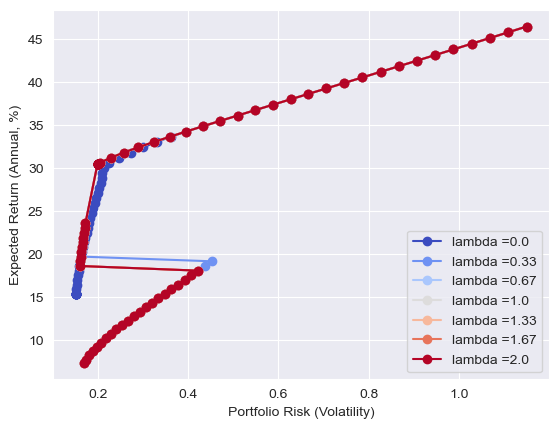

In [211]:
n_lambdas = 7
lambd_array = np.linspace(0, 2, n_lambdas)
# Colormap for plots
cmap = plt.cm.coolwarm 
colors = [cmap(i / (n_lambdas - 1)) for i in range(n_lambdas)]

for i in range(n_lambdas):
    opt_weights, returns, risks = get_efficient_frontier(mu, cov, volume_vector, lambd_array[i], n_points = 70)
    # Convert to annual returns
    returns = [100*((1 + returns[i])**252 - 1) for i in range(len(returns))]
    plt.plot(risks, returns, '-o', color=colors[i], label='lambda ='+str(round(lambd_array[i],2)))
    
plt.xlabel('Portfolio Risk (Volatility)')
plt.ylabel('Expected Return (Annual, %)')
plt.grid(True)
plt.legend()
plt.show()

Seems like the liquidity constraint is not moving the efficient frontier at all, we can work with $\lambda = 0$.

Finally, let us generate sample portfolios on the efficient frontier with high and low risks. 

In [212]:
opt_weights, returns, risks = get_efficient_frontier(mu, cov, volume_vector, lambd = 0, n_points = 100)
returns = [100*((1 + returns[i])**252 - 1) for i in range(len(returns))]

Optimization failed at return: 0.0015333258428376804


In [213]:
min_risk_index = risks.index(min(risks))
high_risk_index = len(risks)-3

In [214]:
high_risk_portfolio = opt_weights[high_risk_index]

sorted_indices = np.argsort(-high_risk_portfolio)
high_risk_portfolio = -1*np.sort(-high_risk_portfolio)

print("A High-Risk Portfolio on the Efficient Frontier")
for i in range(n_assets):
    if round(high_risk_portfolio[i], 5) > 0:
        print(stock_tickers[sorted_indices[i]], round(high_risk_portfolio[i], 4))  

print('Annualized Volatility = ', round(risks[high_risk_index]*100, 2), "%")
print('Average Annual Return (Simple) = ', round(returns[high_risk_index], 2), "%")

A High-Risk Portfolio on the Efficient Frontier
JEPQ 0.9293
VOO 0.0597
FBCG 0.001
BOTZ 0.001
SKYY 0.001
SPY 0.001
VIG 0.001
FBCV 0.001
SOXL 0.001
VTI 0.001
SCHD 0.001
XLC 0.001
GOOGL 0.001
Annualized Volatility =  110.56 %
Average Annual Return (Simple) =  45.72 %


In [216]:
# min_risk_index = 0

low_risk_portfolio = opt_weights[min_risk_index]
sorted_indices = np.argsort(-low_risk_portfolio)
low_risk_portfolio = -1*np.sort(-low_risk_portfolio)
print("A Low-Risk Portfolio on the Efficient Frontier")
for i in range(n_assets):
    # if round(low_risk_portfolio[i], 4) > 0:
    print(stock_tickers[sorted_indices[i]], round(low_risk_portfolio[i], 4))

print('Annualized Volatility = ', round(risks[min_risk_index]*100, 2), "%")
print('Average Annual Return (Simple) = ', round(returns[min_risk_index], 2), "%")

A Low-Risk Portfolio on the Efficient Frontier
VIG 0.2006
VTI 0.1889
SKYY 0.1576
VOO 0.1029
SOXL 0.0954
XLC 0.0817
SCHD 0.0633
GOOGL 0.0612
FBCV 0.0444
SPY 0.001
BOTZ 0.001
FBCG 0.001
JEPQ 0.001
Annualized Volatility =  15.08 %
Average Annual Return (Simple) =  15.4 %


Remove stocks that have less weight and recalculate returns and risks

In [198]:
def get_clean_portfolio(data_stocks, all_tickers, weights, threshold=0.001):
    """
    Filters a portfolio based on weight threshold and computes annualized returns and volatility.
    """

    # Convert to numpy array in case input is not
    weights = np.array(weights)

    # Filter tickers and weights based on threshold
    mask = weights > threshold
    clean_stocks = [ticker for ticker, keep in zip(all_tickers, mask) if keep]
    clean_weights = weights[mask]
    
    
    # Rebalance weights to sum to 1
    clean_weights /= clean_weights.sum()
    print(weights, clean_weights)

    # Get daily returns
    # print(data.columns)
    data_sig = data_stocks[clean_stocks]
    returns = (data_sig / data_sig.shift(1)).dropna() - 1
    cov_matrix = returns.cov()
    mean_returns = returns.mean()

    # Compute portfolio return time series
    portfolio_returns = clean_weights @ mean_returns

    # Annualized return and volatility
    trading_days = 252
    annualized_return = (1+ portfolio_returns)**252 - 1
    annualized_volatility = np.sqrt(clean_weights.T @ cov_matrix @ clean_weights)

    sorted_indices = np.argsort(-clean_weights)
    clean_weights = -1*np.sort(-clean_weights)
    clean_stocks_sorted = []
    for i in range(len(clean_stocks)):
        clean_stocks_sorted.append(clean_stocks[sorted_indices[i]])

    return clean_stocks_sorted, clean_weights, annualized_return, annualized_volatility

In [199]:
# min_risk_index = 70
clean_stocks, clean_weights, annualized_return, vol = get_clean_portfolio(data, stock_tickers, opt_weights[min_risk_index], 0.002)

[0.001      0.001      0.001      0.001      0.1370577  0.03360431
 0.10448619 0.0539336  0.04982254 0.001      0.06402021 0.001
 0.12515079 0.001      0.001      0.02334613 0.001      0.09971438
 0.03821952 0.177473   0.0211678  0.06300382] [0.13830243 0.0339095  0.10543511 0.05442341 0.05027502 0.06460162
 0.12628738 0.02355816 0.10061996 0.03856662 0.17908476 0.02136004
 0.063576  ]


In [200]:
print(clean_stocks)

['BOTZ', 'FBCG', 'VIG', 'FBCV', 'SOXL', 'VTI', 'SPY', 'JEPQ', 'SCHD', 'SKYY', 'XLC', 'GOOGL', 'VOO']


In [201]:
for i in range(len(clean_stocks)):
    print(clean_stocks[i], round(10000*clean_weights[i], 2))
    
print("Annualized return: ", round(100*annualized_return, 2), "%")
# print("Volatility: ", vol)

BOTZ 1790.85
FBCG 1383.02
VIG 1262.87
FBCV 1054.35
SOXL 1006.2
VTI 646.02
SPY 635.76
JEPQ 544.23
SCHD 502.75
SKYY 385.67
XLC 339.09
GOOGL 235.58
VOO 213.6
Annualized return:  18.99 %
